<a href="https://colab.research.google.com/github/Vjais/Deep-Learning-projects/blob/master/Stock_prediction_on_microsoft_data_using_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install quandl

  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection


In [0]:
#Importing libraries
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import quandl
import os
import pickle
import datetime  
import tensorflow as tf
%matplotlib inline  

In [0]:
#Importing and pre processing of dataset
#https://www.quandl.com/api/v3/datasets/WIKI/FB/data.csv
def date_obj_to_str(date_obj):
  return date_obj.strftime('%Y-%m-%d')

def save_pickle(something, path):
  if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
  with open(path, 'wb') as fh:
    pickle.dump(something, fh, pickle.DEFAULT_PROTOCOL)
    
def load_pickle(path):
  with open(path, 'rb') as fh:
    return pickle.load(fh)

def fetch_stock_price(symbol,from_date,to_date,cache_path= './tmp/prices/'):
  assert(from_date <= to_date)
  filename = "{}_{}_{}.pk".format(symbol,str(from_date),str(to_date))
  price_filepath = os.path.join(cache_path,filename)
  try:
    prices = load_pickle(price_filepath)
    print("Data Loaded from local")  
  except: 
    historic = quandl.get("WIKI/"+symbol,start_date=date_obj_to_str(from_date),end_date=date_obj_to_str(to_date))
    prices = historic["Adj. Close"].tolist()
    save_pickle(prices,price_filepath)
  return prices 

In [0]:
def fetch_cosine_values(seq_len,frequency=0.01,noise=0.1):
  np.random.seed(101)
  x = np.arange(0.0, seq_len, 1.0)
  return np.cos(2*np.pi*frequency*x)+np.random.uniform(low=-noise, high=noise,size=seq_len)

def format_dataset (values, temporal_features):
  feat_split = [values[i:i+temporal_features] for i in range(len(values)-temporal_features)]
  feats = np.vstack(feat_split)
  labels =np.array(values[temporal_features:])
  return feats,labels


**`Using regression to predict the future price of a stock`**

---
Given the observation matrix and a real value label, we are initially tempted to approach the problem as a regression problem. In this case, the regression is very simple: from a numerical vector, we want to predict a numerical value. That's not ideal. Treating the problem as a regression problem, we force the algorithm to think that each feature is independent, while instead, they're correlated. In order to evaluate the model, we now create a function that, given the observation matrix, the true labels, and the predicted ones, will output the metrics (in terms of mean square error (MSE) and mean absolute error (MAE) of the prediction

In [0]:
def matrix_to_array(m):
  return np.asarray(m).reshape(-1)

def evaluate_ts(features,y_true,y_pred):
  print("Evaluation of the predictions:")
  print("MSE:",np.mean(np.square(y_true-y_pred)))
  print("mae:",np.mean(np.abs(y_pred-y_true)))
  
  print("Benchmark: if prediction == last feature")
  print("MSE:",np.mean(np.square(features[:,1] - y_true)))
  print("mae:",np.mean(np.abs(features[:,-1]-y_true)))
  
  plt.plot(matrix_to_array(y_true),'b')
  plt.plot(matrix_to_array(y_pred),'r--')
  plt.xlabel("Days")
  plt.ylabel("Predicted and True values")
  plt.title("Predicted(Red) VS Real (Blue)")
  plt.show()

  error=np.abs(matrix_to_array(y_pred)-matrix_to_array(y_true))

  plt.plot(error,'r')
  fit = np.polyfit(range(len(error)),error,deg=1)
  plt.plot(fit[0]*range(len(error))+fit[1],'--')
  plt.xlabel("Days")
  plt.ylabel("Prediction error L1 norm")
  plt.title("Prediction error (absolute) and trendline")
  plt.show()

In [0]:
#Importing tensorflow
import tensorflow as tf 
#from evaluate_ts import evaluate_ts
from tensorflow.contrib import rnn
#from tools import fetch_cosine_values

tf.reset_default_graph()
tf.set_random_seed(101)

**Cosine Signal Prediction with Linear Regression**

---

We start first with the cosine signal and then we move to the stock price prediction.

In [0]:
feat_dimension=20
train_size=250
test_size =250
learning_rate =0.01
optimizer = tf.train.AdamOptimizer
n_epochs =5000

In [0]:
cos_values = fetch_cosine_values(train_size + test_size + feat_dimension)
minibatch_cos_X,minibatch_cos_y = format_dataset(cos_values,feat_dimension)
train_X = minibatch_cos_X[:train_size,:].astype(np.float32)
train_y = minibatch_cos_y[:train_size].reshape((-1,1)).astype(np.float32)
test_X = minibatch_cos_X[train_size:,:].astype(np.float32)
test_y = minibatch_cos_y[train_size:].reshape((-1,1)).astype(np.float32)

X_tf = tf.placeholder("float",shape = (None,feat_dimension),name="X")
y_tf = tf.placeholder("float",shape = (None,1), name="y")

def regression_ANN(x,weights,biases):
  return tf.add(biases,tf.matmul(x,weights))


In [0]:
weights = tf.Variable(tf.truncated_normal([feat_dimension,1],mean=0.0,stddev=1.0),name="weights")
biases = tf.Variable(tf.zeros([1,1]),name="bias")

y_pred = regression_ANN(X_tf,weights,biases)
cost = tf.reduce_mean(tf.square(y_tf-y_pred))
train_op = optimizer(learning_rate).minimize(cost)


Training iteration 0 MSE 4.394244
Training iteration 500 MSE 0.024377052
Training iteration 1000 MSE 0.016965492
Training iteration 1500 MSE 0.010560285
Training iteration 2000 MSE 0.006472269
Training iteration 2500 MSE 0.004514259
Training iteration 3000 MSE 0.0038244915
Training iteration 3500 MSE 0.0036497754
Training iteration 4000 MSE 0.0036177111
Training iteration 4500 MSE 0.0036131802
Test dataset: 0.0044973823
Evaluation of the predictions:
MSE: 0.0044973823
mae: 0.05686415
Benchmark: if prediction == last feature
MSE: 0.99108446
mae: 0.79347515


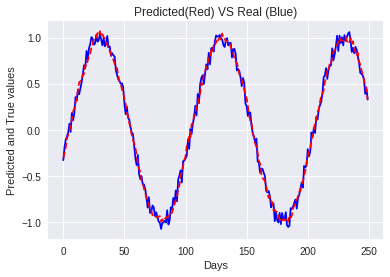

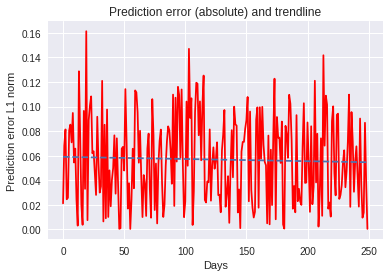

In [12]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    train_cost,_=sess.run([cost,train_op],feed_dict={X_tf:train_X,y_tf:train_y})
    if (i%500==0):
      print("Training iteration",i,"MSE",train_cost)
  test_cost,y_pr =sess.run([cost,y_pred],feed_dict={X_tf:test_X,y_tf:test_y})
  print("Test dataset:",test_cost)
  evaluate_ts(test_X,test_y,y_pr)

**Stock Price Prediction on MSFT**

In [0]:
symbol = "MSFT"
feat_dimension = 20
train_size = 252
test_size = 252 - feat_dimension

#Tensorflow settings
learning_rate = 0.05
optimizer = tf.train.AdamOptimizer
n_epochs = 20000
#Fetch the values, and prepare the train/test split
stock_values = fetch_stock_price(symbol,datetime.date(2015,1,1),datetime.date(2016,12,31))
minibatch_cos_X,minibatch_cos_y = format_dataset(stock_values,feat_dimension)
train_X = minibatch_cos_X[:train_size].astype(np.float32)
train_y = minibatch_cos_y[:train_size].reshape((-1,1)).astype(np.float32)
test_X = minibatch_cos_X[train_size:,:].astype(np.float32)
test_y = minibatch_cos_y[train_size:].reshape((-1,1)).astype(np.float32)


X_tf = tf.placeholder("float",shape = (None,feat_dimension),name="X")
y_tf = tf.placeholder("float",shape = (None,1), name="y")

def regression_ANN(x,weights,biases):
  return tf.add(biases,tf.matmul(x,weights))

weights = tf.Variable(tf.truncated_normal([feat_dimension,1],mean=0.0,stddev=1.0),name="weights")
biases = tf.Variable(tf.zeros([1,1]),name="bias")

y_pred = regression_ANN(X_tf,weights,biases)
cost = tf.reduce_mean(tf.square(y_tf-y_pred))
train_op = optimizer(learning_rate).minimize(cost)


In [14]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    train_cost,_=sess.run([cost,train_op],feed_dict={X_tf:train_X,y_tf:train_y})
    if (i%500==0):
      print("Training iteration",i,"MSE",train_cost)
  test_cost,y_pr =sess.run([cost,y_pred],feed_dict={X_tf:test_X,y_tf:test_y})
  print("Test dataset:",test_cost)


Training iteration 0 MSE 18262.95
Training iteration 500 MSE 9.043295
Training iteration 1000 MSE 6.3396225
Training iteration 1500 MSE 4.696818
Training iteration 2000 MSE 3.7385302
Training iteration 2500 MSE 3.0650237
Training iteration 3000 MSE 2.5068433
Training iteration 3500 MSE 2.0371923
Training iteration 4000 MSE 1.6706964
Training iteration 4500 MSE 1.4258102
Training iteration 5000 MSE 1.2615393
Training iteration 5500 MSE 1.1905115
Training iteration 6000 MSE 1.052608
Training iteration 6500 MSE 0.981944
Training iteration 7000 MSE 0.9232086
Training iteration 7500 MSE 0.8755758
Training iteration 8000 MSE 23.71301
Training iteration 8500 MSE 0.8003608
Training iteration 9000 MSE 0.87735605
Training iteration 9500 MSE 0.7450336
Training iteration 10000 MSE 0.72446764
Training iteration 10500 MSE 0.7037753
Training iteration 11000 MSE 19.908836
Training iteration 11500 MSE 0.6725497
Training iteration 12000 MSE 1.4609956
Training iteration 12500 MSE 0.6485232
Training itera

Evaluation of the predictions:
MSE: 0.54174775
mae: 0.5257894
Benchmark: if prediction == last feature
MSE: 30.033413
mae: 4.6483893


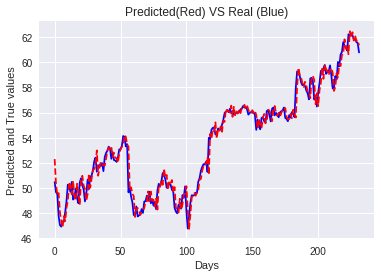

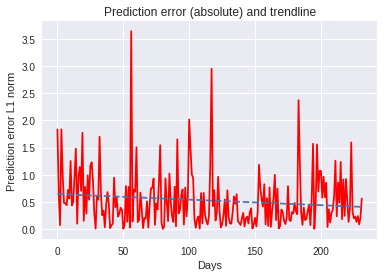

In [15]:
#Evaluation using test data
evaluate_ts(test_X,test_y,y_pr)